In [1]:
import pandas as pd
import numpy as np
import pickle
import os
import ast
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.rdmolfiles import MolFromPDBFile
from scipy.spatial import cKDTree
from tqdm import tqdm
from typing import Dict, Tuple, List, Set
import os, math, ast, json
from Bio.PDB import PDBParser, PDBIO, Select
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, FuncFormatter, PercentFormatter
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.warning')
RDLogger.DisableLog('rdApp.info')

In [3]:
glass_with_cocrystal=pd.read_csv("GLASS/glass_with_cocrystal.csv")

In [4]:
glass_with_cocrystal

,Unnamed: 0,Drug_ID,Target_ID,Y,ligand_pdb_code,co_crystal_PDB
0,0,NDAUXUAQIAJITI-LBPRGKRZSA-N,P07550,5.372685,68H,7DHI
1,35,IPSYPUKKXMNCNQ-PFHKOEEOSA-N,P0DMS8,8.853872,XS0,8X17
2,40,FSRSEANZUZHDHK-UHFFFAOYSA-N,Q9H3N8,7.549751,VCF,8JXW
3,87,KPJZHOPZRAFDTN-ZRGWGRIASA-N,P41595,8.795880,H8J,6DRZ
4,99,VVBFISAUNSXQGZ-UHFFFAOYSA-N,P25105,10.301030,9ER,5ZKP
...,...,...,...,...,...,...
191,2691,HEAUOKZIVMZVQL-VWLOTQADSA-N,P30968,9.045757,F5O,7BR3
192,2705,UWHDLFOAIARROU-XMMPIXPASA-N,P41146,9.140261,DGV,5DHG
193,2709,HYBZWVLPALMACV-KRWDZBQOSA-N,O43613,8.958607,4OT,4ZJC
194,2759,MATPZHBYOVDBLI-JJYYJPOSSA-N,P31422,6.801343,2CG,2E4V


In [5]:
EXPLANATION_METHODS = ["integrated", "shap", "inputxgrad", "guided"]
PICKLE_ROOT         = "attributions/glass"
TOP_PERCENT         = 0.5

def get_top_percent_indices(scores: np.ndarray, percent: float = TOP_PERCENT) -> Set[int]:
    n = len(scores)
    k = max(1, int(n * percent))
    return set(np.argsort(scores)[-k:])

def build_lookup(records: List[dict], drug_key: str, prot_key: str
                ) -> Dict[Tuple[str, str], np.ndarray]:
    lookup = {}
    for rec in records:
        lookup[(rec[drug_key], rec[prot_key])] = rec["attributions"]
    return lookup

def load_method_lookups(root: str,
                        methods: List[str],
                        drug_key: str = "drug_id",
                        prot_key: str = "prot_id"
                       ) -> Dict[str, Dict[Tuple[str,str], np.ndarray]]:
    lookups = {}
    for m in methods:
        path = os.path.join(root, f"{m}.pkl")
        with open(path, "rb") as f:
            recs = pickle.load(f)
        lookups[m] = build_lookup(recs, drug_key, prot_key)
    return lookups

def compute_overlaps_for_all(meta_df: pd.DataFrame,
                             lookups: Dict[str, Dict[Tuple[str,str], np.ndarray]],
                             methods: List[str],
                             top_percent: float
                            ) -> pd.DataFrame:
    meta_df = meta_df.copy()
    meta_df["num_overlap"] = 0
    meta_df["overlapping_nodes"] = [[] for _ in range(len(meta_df))]

    for idx, row in meta_df.iterrows():
        key = (row["Drug_ID"], row["Target_ID"])
        # Check for missing keys in any method
        missing_methods = [m for m in methods if key not in lookups[m]]
        if missing_methods:
            print(f"Pair {key} not found in: {', '.join(missing_methods)}")
            continue

        top_sets = []
        for m in methods:
            arr = lookups[m][key]
            top_sets.append(get_top_percent_indices(arr, percent=top_percent))

        consensus = sorted(set.intersection(*top_sets))
        meta_df.at[idx, "num_overlap"] = len(consensus)
        meta_df.at[idx, "overlapping_nodes"] = consensus

    return meta_df

if __name__ == "__main__":

    meta_df = glass_with_cocrystal  

    lookups = load_method_lookups(
        PICKLE_ROOT,
        EXPLANATION_METHODS,
        drug_key="drug_id",
        prot_key="prot_id"
    )

    result_df = compute_overlaps_for_all(
        meta_df,
        lookups,
        EXPLANATION_METHODS,
        TOP_PERCENT
    )

    print(result_df.head())
    result_df.to_csv("master_with_overlaps.csv", index=False)


Pair ('SGEGOXDYSFKCPT-UHFFFAOYSA-N', 'P08908') not found in: integrated, shap, inputxgrad, guided
Pair ('NEMHKCNXXRQYRF-UHFFFAOYSA-N', 'Q9H244') not found in: integrated, shap, inputxgrad, guided
Pair ('BKUIZWILNWHFHD-UHFFFAOYSA-N', 'P41594') not found in: integrated, shap, inputxgrad, guided
Pair ('ZFPZEYHRWGMJCV-ZHALLVOQSA-N', 'P41594') not found in: integrated, shap, inputxgrad, guided
Pair ('KXXKUWQMQUYUSE-UHFFFAOYSA-N', 'P21554') not found in: integrated, shap, inputxgrad, guided
Pair ('QLYKJCMUNUWAGO-GAJHUEQPSA-N', 'P21554') not found in: integrated, shap, inputxgrad, guided
Pair ('VLZBRVJVCCNPRJ-KPHUOKFYSA-N', 'Q13255') not found in: integrated, shap, inputxgrad, guided
Pair ('VLZBRVJVCCNPRJ-KPHUOKFYSA-N', 'P41594') not found in: integrated, shap, inputxgrad, guided
Pair ('GDLNHSUSOZEAOR-UHFFFAOYSA-N', 'P25105') not found in: integrated, shap, inputxgrad, guided
Pair ('FQAXDSVNYVVQSE-UHFFFAOYSA-N', 'P41594') not found in: integrated, shap, inputxgrad, guided
Pair ('UPDNOLJVPHHEC

In [6]:
smiles=pd.read_csv("datasets/glass/resources/tables/lig.tsv",sep="\t")

In [7]:
smiles

,Drug_ID,Drug
0,GCWNBWOAXTZZMS-JDSSLJPYSA-N,CC(C)CONC(=O)[C@@H]1[C@H]([C@H](C(O1)N2C=NC3=C...
1,KLHZZCXEMHQCHW-UHFFFAOYSA-N,CCC1=C(C(C(=C(N1)COCC[NH3+])C(=O)NCC)C2=CC=C(C...
2,MJTKHTWGWXGNME-UHFFFAOYSA-N,C1CCC(CC1)NCCCCC2=CN=CN2
3,LNNRXCJKYSSUPF-UHFFFAOYSA-N,CCCC(=O)N1CCC(CC1)N2CCC(CC2)C(=C)C3=CC=C(C=C3)...
4,QUPPZULLRXQLGP-BHVANESWSA-N,CC1=CC(=C(C=C1)C2=CC(=C(C=C2)O)Cl)NC(=O)OC3CCN...
...,...,...
70512,WHZALKOISDRHIT-UHFFFAOYSA-N,CCCOC(=O)C1=CN=C2C(=C1NC3CC3)C=NN2CC(C4=CC=CC=...
70513,NEUMZXQQTUBMDK-HNNXBMFYSA-N,C[C@@H](C1=CC=C(C=C1)S(=O)(=O)C2=CC=CC=C2S(=O)...
70514,FQRFQQLJZXACCG-UHFFFAOYSA-N,C1=CC(=CC(=C1)Br)NC2=NC=NC3=C2C=C(C=C3)F
70515,VBBPAGAXRSVWOW-LEWJYISDSA-N,CN([C@H](CN1CC[C@@H](C1)O)C2=CC=CC=C2)C(=O)CC(...


In [8]:
smiles_lookup = smiles[['Drug_ID','Drug']].rename(columns={'Drug':'smiles'})

In [9]:
result_df = result_df.merge(smiles_lookup, on='Drug_ID', how='left')

In [10]:
result_df

,Drug_ID,Target_ID,Y,ligand_pdb_code,co_crystal_PDB,num_overlap,overlapping_nodes,smiles
0,NDAUXUAQIAJITI-LBPRGKRZSA-N,P07550,5.372685,68H,7DHI,4,"[0, 2, 3, 15]",CC(C)(C)NC[C@@H](C1=CC(=C(C=C1)O)CO)O
1,IPSYPUKKXMNCNQ-PFHKOEEOSA-N,P0DMS8,8.853872,XS0,8X17,4,"[3, 5, 19, 28]",CNC(=O)[C@@H]1[C@H]([C@H]([C@@H](O1)N2C=NC3=C2...
2,FSRSEANZUZHDHK-UHFFFAOYSA-N,Q9H3N8,7.549751,VCF,8JXW,1,[9],CN1CCN(CC1)C2=NC3=C(C=C(C=C3)Cl)OC4=CC=CC=C42
3,KPJZHOPZRAFDTN-ZRGWGRIASA-N,P41595,8.795880,H8J,6DRZ,3,"[6, 14, 19]",CC[C@@H](CO)NC(=O)[C@H]1CN([C@@H]2CC3=CN(C4=CC...
4,VVBFISAUNSXQGZ-UHFFFAOYSA-N,P25105,10.301030,9ER,5ZKP,5,"[8, 12, 13, 16, 26]",CC(C)C1=CC(=C(C(=C1)C(C)C)C2=CSC(=N2)N(CCN(C)C...
...,...,...,...,...,...,...,...,...
191,HEAUOKZIVMZVQL-VWLOTQADSA-N,P30968,9.045757,F5O,7BR3,8,"[1, 2, 3, 8, 10, 11, 37, 40]",CC1=C(C(=O)N(C(=O)N1CC2=C(C=CC=C2F)C(F)(F)F)C[...
192,UWHDLFOAIARROU-XMMPIXPASA-N,P41146,9.140261,DGV,5DHG,4,"[5, 6, 9, 31]",C1C[C@@H](N(C1)CC2=CC=CC=C2)C(=O)NCCCN3CCC(CC3...
193,HYBZWVLPALMACV-KRWDZBQOSA-N,O43613,8.958607,4OT,4ZJC,2,"[8, 31]",CC1=NC(=C(S1)C2=CC=CC=C2F)C(=O)N3CCC[C@H]3CC4=...
194,MATPZHBYOVDBLI-JJYYJPOSSA-N,P31422,6.801343,2CG,2E4V,0,[],[C@@H]1([C@@H](C1[C@@H](C(=O)O)N)C(=O)O)C(=O)O


Overlap

In [ ]:


df_input     = result_df.copy()  
pdb_folder      = "GLASS/cocrystal_pdb_files"
lig_out         = "extracted_ligs"
summary_csv_out = "proximity_glass.csv"
thresholds      = [2.0, 3.0, 4.0]
print_limit     = 20     # how many rows to print mapping info


df = (result_df.copy() if 'result_df' in globals() and isinstance(result_df, pd.DataFrame)
      else df_input if isinstance(df_input, pd.DataFrame)
      else None)



os.makedirs(lig_out, exist_ok=True)

parser = PDBParser(QUIET=True)
io     = PDBIO()

class LigandSelect(Select):
    def __init__(self, target): self.target = target
    def accept_residue(self, residue):
        
        return residue.id[0] != " " and residue.get_resname().strip() == self.target

if df is None:
    raise ValueError("No input DataFrame provided. Set 'result_df' or 'df_input' to a DataFrame.")

records = []
failed  = []

for idx, row in enumerate(df.itertuples()):
    pdb_id        = str(row.co_crystal_PDB).strip()
    lig_code      = str(row.ligand_pdb_code).strip()
    smiles        = str(row.smiles).strip()
    prot_id       = str(row.Target_ID).strip()
    drug_id       = str(row.Drug_ID).strip()
    overlapping_nodes = row.overlapping_nodes  

    pdb_path = os.path.join(pdb_folder, f"{pdb_id}.pdb")
    if not os.path.exists(pdb_path):
        failed.append((pdb_id, lig_code, "missing pdb"))
        continue

  
    struct = parser.get_structure(pdb_id, pdb_path)

  
    io.set_structure(struct)
    lig_file = os.path.join(lig_out, f"{pdb_id}_{lig_code}.pdb")
    io.save(lig_file, LigandSelect(lig_code))

    
    try:
        frag = Chem.MolFromPDBFile(lig_file, sanitize=False)
        Chem.SanitizeMol(frag)
    except Exception as e:
        failed.append((pdb_id, lig_code, f"RDKit load/sanitize ligand failed: {e}"))
        continue

    try:
        tpl  = Chem.MolFromSmiles(smiles)
        Chem.SanitizeMol(tpl)
    except Exception as e:
        failed.append((pdb_id, lig_code, f"RDKit SMILES failed: {e}"))
        continue

    frag_nh = Chem.RemoveHs(frag)
    tpl_nh  = Chem.RemoveHs(tpl)

   
    ranks = list(Chem.CanonicalRankAtoms(tpl_nh, breakTies=True))
    tpl_nh = Chem.RenumberAtoms(tpl_nh, ranks)

   
    try:
        mapped     = AllChem.AssignBondOrdersFromTemplate(tpl_nh, frag_nh)
        full_match = mapped.GetSubstructMatch(tpl_nh)
    except Exception:
      
        full_match = frag_nh.GetSubstructMatch(tpl_nh)
        if not full_match or len(full_match) != tpl_nh.GetNumAtoms():
            failed.append((pdb_id, lig_code, "mapping failed"))
            continue

 
    try:
        imp_tpl_idxs = row.overlapping_nodes
       
        if isinstance(imp_tpl_idxs, str):
            imp_tpl_idxs = ast.literal_eval(imp_tpl_idxs)
        imp_tpl_idxs = [int(i) for i in imp_tpl_idxs]
    except Exception:
        failed.append((pdb_id, lig_code, "invalid overlapping_nodes"))
        continue

    try:
        imp_frag_idxs = [int(full_match[int(i)]) for i in imp_tpl_idxs]
    except Exception:
        failed.append((pdb_id, lig_code, "failed to map important atoms"))
        continue

    if idx < print_limit:
        print(f"\nMapping for {pdb_id} {lig_code}:")
        for ti in imp_tpl_idxs:
            ti_py = int(ti)
            fi_py = int(full_match[ti_py])
            s1  = tpl_nh.GetAtomWithIdx(ti_py).GetSymbol()
            s2  = frag_nh.GetAtomWithIdx(fi_py).GetSymbol()
            print(f"  SMILES atom {ti_py} ({s1}) → PDB atom {fi_py} ({s2})")

    mismatch = False
    for ti, fi in zip(imp_tpl_idxs, imp_frag_idxs):
        if tpl_nh.GetAtomWithIdx(int(ti)).GetSymbol() != frag_nh.GetAtomWithIdx(int(fi)).GetSymbol():
            mismatch = True
            break
    if mismatch:
        failed.append((pdb_id, lig_code, "element mismatch"))

    prot_coords = []
    prot_atoms_flat = []
    for model in struct:
        for ch in model:
            for res in ch:
                if res.id[0] == " ":  
                    for a in res:
                        prot_coords.append(a.get_coord())
                        prot_atoms_flat.append(a)
    if not prot_coords:
        failed.append((pdb_id, lig_code, "no protein atoms"))
        continue
    tree = cKDTree(np.array(prot_coords, dtype=float))

    conf = frag_nh.GetConformer()
    all_dists, all_idxs = [], []
    for i in range(frag_nh.GetNumAtoms()):
        pos = conf.GetAtomPosition(i)
        d, idx_nn = tree.query((pos.x, pos.y, pos.z), k=1)
        all_dists.append(float(d))
        all_idxs.append(int(idx_nn))

    imp_dists    = [all_dists[i] for i in imp_frag_idxs]
    imp_elements = [frag_nh.GetAtomWithIdx(i).GetSymbol() for i in imp_frag_idxs]
    prot_imp_idxs = [all_idxs[i] for i in imp_frag_idxs]  

    lig_atom_ids = []
    try:
        for i_frag in imp_frag_idxs:
            info = frag_nh.GetAtomWithIdx(int(i_frag)).GetPDBResidueInfo()
            if info is None:
                raise ValueError("missing PDB residue info on RDKit atom")
            lig_atom_ids.append({
                "chain": (info.GetChainId() or "").strip(),
                "resi":  str(info.GetResidueNumber()),
                "resn":  (info.GetResidueName() or "").strip(),
                "name":  (info.GetName() or "").strip()
            })
    except Exception as e:
        failed.append((pdb_id, lig_code, f"cannot build lig_atom_ids: {e}"))
        continue

    clauses = [
        f"(chain {a['chain']} and resi {a['resi']} and resn {a['resn']} and name {a['name']})"
        for a in lig_atom_ids
    ]
    pymol_clause = " or ".join(clauses) if clauses else ""
    pml_sel_name = f"hot_{pdb_id}_{lig_code}"
    pml_path     = os.path.join(lig_out, f"{pdb_id}_{lig_code}_hot.pml")
    with open(pml_path, "w", encoding="utf-8") as fp:
        fp.write(f"select {pml_sel_name}, ({pymol_clause})\n")
        fp.write(f"show spheres, {pml_sel_name}\n")
        fp.write(f"color red, {pml_sel_name}\n")

 
    rec = {
        "structure_ID":          pdb_id,
        "ligand_pdb_code":       lig_code,
        "Target_ID":             prot_id,
        "Drug_id":               drug_id,
        "smiles":                smiles,
        "overlapping_nodes":     overlapping_nodes,
        "protein_imp_indexes":   prot_imp_idxs,     
        "num_imp":               len(imp_frag_idxs),
        "num_all":               frag_nh.GetNumAtoms(),
        "imp_atom_elements":     imp_elements,
        "imp_atom_distances":    imp_dists,
        "lig_atom_ids":          json.dumps(lig_atom_ids)
    }


    for thr in thresholds:
        all_within = [i for i, d in enumerate(all_dists) if d <= thr]
        imp_within = [i for i in imp_frag_idxs if all_dists[i] <= thr]
        rec[f"all_within_{thr:.1f}A"]      = all_within
        rec[f"num_all_within_{thr:.1f}A"]  = len(all_within)
        rec[f"prop_all_within_{thr:.1f}A"] = (len(all_within) / frag_nh.GetNumAtoms()) if frag_nh.GetNumAtoms() else math.nan
        rec[f"imp_within_{thr:.1f}A"]      = imp_within
        rec[f"num_imp_within_{thr:.1f}A"]  = len(imp_within)
        rec[f"prop_imp_within_{thr:.1f}A"] = (len(imp_within) / len(imp_frag_idxs)) if imp_frag_idxs else math.nan

    records.append(rec)


if failed:
    print(f"\nSkipped {len(failed)} ligands:")
    for pid, lcode, reason in failed:
        print(f"  • {pid} {lcode}: {reason}")


summary_df = pd.DataFrame(records)
base_cols = [
    "structure_ID","ligand_pdb_code","Target_ID","Drug_id","smiles",
    "overlapping_nodes","protein_imp_indexes","num_imp","num_all","imp_atom_elements","imp_atom_distances",
    "lig_atom_ids"
]
cols = base_cols[:]
for thr in thresholds:
    cols += [
        f"imp_within_{thr:.1f}A", f"num_imp_within_{thr:.1f}A", f"prop_imp_within_{thr:.1f}A",
        f"all_within_{thr:.1f}A", f"num_all_within_{thr:.1f}A", f"prop_all_within_{thr:.1f}A",
    ]

cols = [c for c in cols if c in summary_df.columns]
summary_df = summary_df[cols]

summary_df.to_csv(summary_csv_out, index=False)
print(f"\n✔ Done! Full summary written to {summary_csv_out}")
print(f"   PyMOL scripts written under: {os.path.abspath(lig_out)}")


[21:00:20] WARNING: More than one matching pattern found - picking one




Mapping for 7DHI 68H:
  SMILES atom 0 (C) → PDB atom 14 (C)
  SMILES atom 2 (C) → PDB atom 13 (C)
  SMILES atom 3 (C) → PDB atom 15 (C)
  SMILES atom 15 (C) → PDB atom 16 (C)

Mapping for 8X17 XS0:
  SMILES atom 3 (N) → PDB atom 8 (N)
  SMILES atom 5 (I) → PDB atom 29 (I)
  SMILES atom 19 (N) → PDB atom 0 (N)
  SMILES atom 28 (C) → PDB atom 9 (C)


[21:00:21] WARNING: More than one matching pattern found - picking one

[21:00:21] WARNING: More than one matching pattern found - picking one




Mapping for 8JXW VCF:
  SMILES atom 9 (C) → PDB atom 20 (C)

Mapping for 6DRZ H8J:
  SMILES atom 6 (N) → PDB atom 23 (N)
  SMILES atom 14 (C) → PDB atom 11 (C)
  SMILES atom 19 (O) → PDB atom 24 (O)

Mapping for 5ZKP 9ER:
  SMILES atom 8 (C) → PDB atom 17 (C)
  SMILES atom 12 (C) → PDB atom 26 (C)
  SMILES atom 13 (C) → PDB atom 15 (C)
  SMILES atom 16 (C) → PDB atom 22 (C)
  SMILES atom 26 (C) → PDB atom 21 (C)


[21:00:21] WARNING: More than one matching pattern found - picking one

[21:00:21] WARNING: More than one matching pattern found - picking one




Mapping for 6HLP GAW:
  SMILES atom 16 (C) → PDB atom 13 (C)

Mapping for 6LUQ GMJ:
  SMILES atom 12 (C) → PDB atom 10 (C)
  SMILES atom 13 (C) → PDB atom 14 (C)

Mapping for 3RFM CFF:
  SMILES atom 2 (C) → PDB atom 8 (C)


[21:00:21] WARNING: More than one matching pattern found - picking one

[21:00:21] WARNING: More than one matching pattern found - picking one




Mapping for 6ME3 JEY:
  SMILES atom 5 (C) → PDB atom 7 (C)
  SMILES atom 12 (C) → PDB atom 16 (C)
  SMILES atom 15 (O) → PDB atom 5 (O)
  SMILES atom 21 (C) → PDB atom 0 (C)

Mapping for 6ME6 JEY:
  SMILES atom 5 (C) → PDB atom 7 (C)
  SMILES atom 10 (C) → PDB atom 15 (C)
  SMILES atom 12 (C) → PDB atom 16 (C)
  SMILES atom 15 (O) → PDB atom 5 (O)

Mapping for 4LDO ALE:
  SMILES atom 1 (C) → PDB atom 4 (C)
  SMILES atom 6 (O) → PDB atom 6 (O)
  SMILES atom 7 (O) → PDB atom 7 (O)

Mapping for 9CBL ALE:
  SMILES atom 11 (C) → PDB atom 11 (C)

Mapping for 8THL ALE:
  SMILES atom 7 (O) → PDB atom 7 (O)


[21:00:21] WARNING: More than one matching pattern found - picking one

[21:00:22] WARNING: More than one matching pattern found - picking one




Mapping for 8EF5 7V7:
  SMILES atom 2 (C) → PDB atom 4 (C)
  SMILES atom 17 (C) → PDB atom 11 (C)

Mapping for 4O9R CY8:
  SMILES atom 1 (C) → PDB atom 3 (C)
  SMILES atom 2 (C) → PDB atom 4 (C)
  SMILES atom 10 (C) → PDB atom 26 (C)
  SMILES atom 21 (C) → PDB atom 14 (C)

Mapping for 6BT5 E7P:


[21:00:22] WARNING: More than one matching pattern found - picking one

[21:00:22] WARNING: More than one matching pattern found - picking one




Mapping for 8WG9 E7P:

Mapping for 7E9H SEP:


[21:00:22] WARNING: More than one matching pattern found - picking one

[21:00:22] WARNING: More than one matching pattern found - picking one

[21:00:22] WARNING: More than one matching pattern found - picking one




Mapping for 8FYL YG7:

Mapping for 5XPR K86:
  SMILES atom 1 (O) → PDB atom 37 (O)
  SMILES atom 15 (C) → PDB atom 36 (C)
  SMILES atom 18 (C) → PDB atom 31 (C)
  SMILES atom 25 (N) → PDB atom 23 (N)
  SMILES atom 27 (N) → PDB atom 22 (N)
  SMILES atom 32 (N) → PDB atom 20 (N)
  SMILES atom 37 (N) → PDB atom 26 (N)


[21:00:22] WARNING: More than one matching pattern found - picking one

[21:00:22] WARNING: More than one matching pattern found - picking one

[21:00:23] WARNING: More than one matching pattern found - picking one

[21:00:23] WARNING: More than one matching pattern found - picking one

[21:00:23] WARNING: More than one matching pattern found - picking one

[21:00:23] WARNING: More than one matching pattern found - picking one

[21:00:23] WARNING: More than one matching pattern found - picking one

[21:00:24] WARNING: More than one matching pattern found - picking one

[21:00:24] WARNING: More than one matching pattern found - picking one

[21:00:24] WARNING: More than one matching pattern found - picking one

[21:00:24] WARNING: More than one matching pattern found - picking one

[21:00:24] WARNING: More than one matching pattern found - picking one

[21:00:24] WARNING: More than one matching pattern found - picking one

[21:00:25] WARNING: More than one matching pattern found - picki


Skipped 3 ligands:
  • 3RZE D7V: mapping failed
  • 5TGZ ZDG: mapping failed
  • 8XXV IMN: missing pdb

✔ Done! Full summary written to proximity_glass.csv
   PyMOL scripts written under: d:\Pipeline\rindti\extracted_ligs


In [13]:

filtered = summary_df[summary_df['num_imp'] != 0]




In [14]:
filtered

,structure_ID,ligand_pdb_code,Target_ID,Drug_id,smiles,overlapping_nodes,protein_imp_indexes,num_imp,num_all,imp_atom_elements,...,prop_imp_within_3.0A,all_within_3.0A,num_all_within_3.0A,prop_all_within_3.0A,imp_within_4.0A,num_imp_within_4.0A,prop_imp_within_4.0A,all_within_4.0A,num_all_within_4.0A,prop_all_within_4.0A
0,7DHI,68H,P07550,NDAUXUAQIAJITI-LBPRGKRZSA-N,CC(C)(C)NC[C@@H](C1=CC(=C(C=C1)O)CO)O,"[0, 2, 3, 15]","[6143, 6143, 6143, 6758]",4,17,"[C, C, C, C]",...,0.00,"[0, 4, 12]",3,0.176471,"[14, 13, 15, 16]",4,1.00,"[0, 1, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 1...",15,0.882353
1,8X17,XS0,P0DMS8,IPSYPUKKXMNCNQ-PFHKOEEOSA-N,CNC(=O)[C@@H]1[C@H]([C@H]([C@@H](O1)N2C=NC3=C2...,"[3, 5, 19, 28]","[3221, 3825, 4424, 3911]",4,30,"[N, I, N, C]",...,0.25,"[8, 17, 27, 28]",4,0.133333,"[8, 29, 0, 9]",4,1.00,"[0, 1, 2, 3, 5, 7, 8, 9, 10, 11, 12, 13, 14, 1...",26,0.866667
2,8JXW,VCF,Q9H3N8,FSRSEANZUZHDHK-UHFFFAOYSA-N,CN1CCN(CC1)C2=NC3=C(C=C(C=C3)Cl)OC4=CC=CC=C42,[9],[7507],1,23,[C],...,0.00,[],0,0.000000,[],0,0.00,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14,...",20,0.869565
3,6DRZ,H8J,P41595,KPJZHOPZRAFDTN-ZRGWGRIASA-N,CC[C@@H](CO)NC(=O)[C@H]1CN([C@@H]2CC3=CN(C4=CC...,"[6, 14, 19]","[725, 686, 2322]",3,26,"[N, C, O]",...,0.00,"[22, 25]",2,0.076923,"[23, 11, 24]",3,1.00,"[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 13, 16, 18...",19,0.730769
4,5ZKP,9ER,P25105,VVBFISAUNSXQGZ-UHFFFAOYSA-N,CC(C)C1=CC(=C(C(=C1)C(C)C)C2=CSC(=N2)N(CCN(C)C...,"[8, 12, 13, 16, 26]","[724, 552, 745, 1210, 3105]",5,33,"[C, C, C, C, C]",...,0.00,[31],1,0.030303,"[17, 26, 22, 21]",4,0.80,"[0, 2, 7, 8, 9, 11, 12, 13, 17, 18, 21, 22, 23...",22,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,7T8X,ACH,P08172,OIPILFWXSMYKGL-UHFFFAOYSA-N,CC(=O)OCC[N+](C)(C)C,"[3, 4, 6]","[646, 669, 1756]",3,10,"[C, C, C]",...,0.00,[],0,0.000000,"[8, 1, 9]",3,1.00,"[1, 2, 3, 4, 5, 6, 7, 8, 9]",9,0.900000
188,7BR3,F5O,P30968,HEAUOKZIVMZVQL-VWLOTQADSA-N,CC1=C(C(=O)N(C(=O)N1CC2=C(C=CC=C2F)C(F)(F)F)C[...,"[1, 2, 3, 8, 10, 11, 37, 40]","[43, 43, 43, 1389, 43, 566, 63, 3281]",8,45,"[C, C, C, O, C, O, O, C]",...,0.00,[42],1,0.022222,"[27, 26, 28, 44, 25, 40, 41, 20]",8,1.00,"[0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 1...",43,0.955556
189,5DHG,DGV,P41146,UWHDLFOAIARROU-XMMPIXPASA-N,C1C[C@@H](N(C1)CC2=CC=CC=C2)C(=O)NCCCN3CCC(CC3...,"[5, 6, 9, 31]","[633, 673, 1119, 459]",4,64,"[C, C, N, C]",...,0.00,"[3, 13, 38, 45]",4,0.062500,[24],1,0.25,"[0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 1...",44,0.687500
190,4ZJC,4OT,O43613,HYBZWVLPALMACV-KRWDZBQOSA-N,CC1=NC(=C(S1)C2=CC=CC=C2F)C(=O)N3CCC[C@H]3CC4=...,"[8, 31]","[3570, 1559]",2,32,"[C, C]",...,0.00,[],0,0.000000,"[21, 23]",2,1.00,"[0, 1, 2, 3, 4, 5, 8, 10, 11, 12, 13, 14, 15, ...",25,0.781250


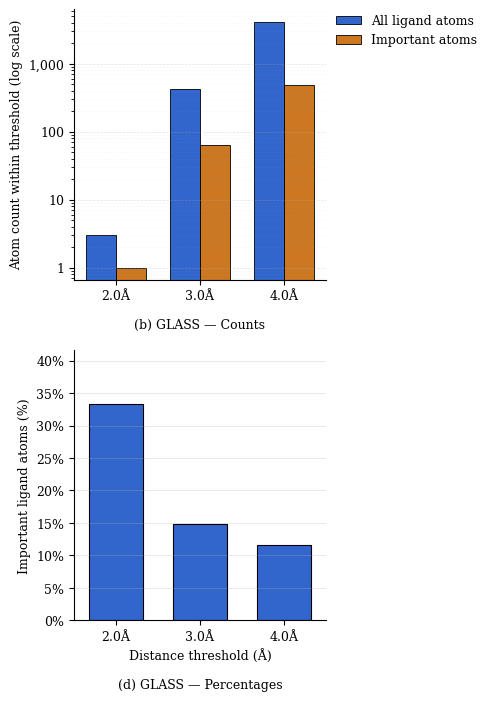

In [ ]:



thresholds = [2.0, 3.0, 4.0]


total_all = [filtered[f'num_all_within_{t:.1f}A'].sum() for t in thresholds]
total_imp = [filtered[f'num_imp_within_{t:.1f}A'].sum() for t in thresholds]
df_pct = pd.DataFrame({
    'threshold_A':       thresholds,
    'important_atoms':   total_imp,
    'total_ligand_atoms': total_all
})


percentages = df_pct["percent_important"].values

plt.rcParams.update({
    "font.size": 9,
    "font.family": "serif",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.linewidth": 0.8,
})


fig = plt.figure(figsize=(4.8, 7.0), constrained_layout=True)
gs  = fig.add_gridspec(nrows=4, ncols=1,
                       height_ratios=[1.0, 0.11, 1.0, 0.11])
fig.set_constrained_layout_pads(hspace=0.05, wspace=0.02)

ax_top = fig.add_subplot(gs[0, 0])
ax_cap_top = fig.add_subplot(gs[1, 0]); ax_cap_top.axis("off")
ax_bot = fig.add_subplot(gs[2, 0], sharex=ax_top)
ax_cap_bot = fig.add_subplot(gs[3, 0]); ax_cap_bot.axis("off")

x = np.arange(len(thresholds))
xticklabels = [f"{t:.1f}Å" for t in thresholds]
c_all, c_imp = "#3366CC", "#CC7722"
bar_width = 0.36


ax_top.bar(x - bar_width/2, total_all, width=bar_width,
           label="All ligand atoms", color=c_all,
           edgecolor="black", linewidth=0.6)
ax_top.bar(x + bar_width/2, total_imp, width=bar_width,
           label="Important atoms", color=c_imp,
           edgecolor="black", linewidth=0.6)

ax_top.set_yscale("log")
ax_top.yaxis.set_major_locator(LogLocator(base=10, numticks=6))
ax_top.yaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2,10)*0.1, numticks=12))
ax_top.yaxis.set_major_formatter(FuncFormatter(lambda v, p: f"{int(v):,}" if v >= 1 else f"{v:g}"))
ax_top.set_ylabel("Atom count within threshold (log scale)")
ax_top.grid(True, axis="y", which="major", linestyle="--", linewidth=0.5, alpha=0.35)
ax_top.grid(True, axis="y", which="minor", linestyle=":", linewidth=0.4, alpha=0.2)
ax_top.legend(frameon=False, bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)


ax_cap_top.text(0.5, 0.55, "(b) GLASS — Counts",
                ha="center", va="center", fontsize=9)


ax_bot.bar(x, percentages, width=0.65, color=c_all,
           edgecolor="black", linewidth=0.8)

ax_bot.set_ylabel("Important ligand atoms (%)")
ax_bot.yaxis.set_major_formatter(PercentFormatter(100, decimals=0))
ax_bot.set_ylim(0, percentages.max() * 1.25)
ax_bot.grid(axis="y", linewidth=0.5, alpha=0.4)

ax_bot.set_xticks(x)
ax_bot.set_xticklabels(xticklabels)
ax_bot.set_xlabel("Distance threshold (Å)")

ax_cap_bot.text(0.5, 0.55, "(d) GLASS — Percentages",
                ha="center", va="center", fontsize=9)

fig.savefig("glass_counts_plus_percentages_labeled.pdf")
fig.savefig("glass_counts_plus_percentages_labeled.png", dpi=600)
plt.show()
